# Comparing Different Optimizers with Callback Function


In [ ]:
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.variational_forms import RY
from qiskit import BasicAer
from qiskit.aqua.algorithms.classical import ExactEigensolver
import matplotlib.pyplot as plt

# Define Hamiltonian
This is an arbitrary Hamiltonian that we build up from hand that does not necessarily represent anything specific.  We will discuss details further in the next section

In [2]:
pauli_dict = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.052373245772859}, "label": "II"},
              {"coeff": {"imag": 0.0, "real": 0.39793742484318045}, "label": "ZI"},
              {"coeff": {"imag": 0.0, "real": -0.39793742484318045}, "label": "IZ"},
              {"coeff": {"imag": 0.0, "real": -0.01128010425623538}, "label": "ZZ"},
              {"coeff": {"imag": 0.0, "real": 0.18093119978423156}, "label": "XX"}
              ]
}

qubit_op = WeightedPauliOperator.from_dict(pauli_dict)
num_qubits = qubit_op.num_qubits
print('Number of qubits: {}'.format(num_qubits))

Number of qubits: 2


### Picking Quantum Circuit to Represent Wavefunction
We will be discussing details on these waveforms tomorrow

In [3]:
init_state = Zero(num_qubits)
var_form = RY(num_qubits, initial_state=init_state)

# Using Simulator Backend

In [4]:
backend = BasicAer.get_backend('statevector_simulator')

## Import Different Optimizers and Compare

In [5]:
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP
import numpy as np
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms.adaptive import VQE

In [31]:
optimizers = [COBYLA, L_BFGS_B, SLSQP]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
param_vals = np.empty([len(optimizers)], dtype=object)
num_qubits = qubit_op.num_qubits

for i in range(len(optimizers)):
    aqua_globals.random_seed = 250
    optimizer = optimizers[i]()
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
    params = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
  
    algo = VQE(qubit_op, var_form, optimizer, callback=store_intermediate_result)
    quantum_instance = QuantumInstance(backend=backend)  
    algo_result = algo.run(quantum_instance)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    param_vals[i] = np.asarray(params)
print('\rOptimization complete      ');

Optimization complete      


In [32]:
ee = ExactEigensolver(qubit_op)
result = ee.run()
ref = result['energy']
print('Reference value: {}'.format(ref))

Reference value: -1.8572750302023804


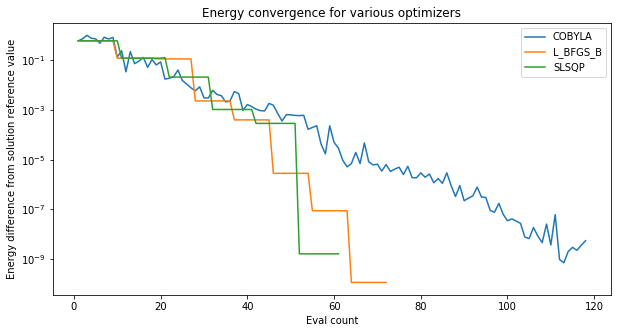

In [33]:
plt.figure(figsize=(10,5))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=optimizers[i].__name__)
plt.xlabel('Eval count')
plt.ylabel('Energy difference from solution reference value')
plt.title('Energy convergence for various optimizers')
plt.yscale('log')
plt.legend(loc='upper right')